
# 🧪 Clinical Trial: Hipponol Intervention Study

This notebook explores data from a simulated 2-year clinical trial testing the effects of a novel nutrient, **Hipponol**, on blood pressure and survival.

## Study Design

- **Population**: 500 participants, aged 40–70, male/female, smokers and non-smokers.
- **Design**: Randomised controlled trial (RCT), 1:1 allocation to Hipponol vs. placebo.
- **Blinding**: Double-blind.
- **Duration**: 2-year follow-up.
- **Outcomes**:
  - **Primary**: Survival at 2 years.
  - **Secondary**: Change in systolic blood pressure (SBP) from baseline to follow-up.

## Analysis Plan

This notebook will follow key elements of the **CONSORT guidelines** for RCT reporting.

### 🔍 Descriptive Analysis (Baseline)

- Generate a **Table 1** comparing baseline characteristics (age, sex, smoking status, baseline SBP) between groups.
- Use appropriate statistical tests:
  - Continuous variables: t-test or Mann–Whitney U
  - Categorical variables: Chi-squared test

### 📉 Outcome Analysis

#### 1. Frequentist Approach

- **Survival**:
  - Logistic regression
  - Kaplan–Meier survival curves by group.
  - Log-rank test and Cox proportional hazards model.


- **Blood Pressure**:
  - Compare change in SBP using paired and unpaired t-tests.
  - Adjust for baseline covariates using linear regression.


#### 2. Bayesian Approach

- Logistic regression 
- Estimate group differences in SBP change using Bayesian linear models.
- Report posterior means, 95% credible intervals, and probability of benefit.

### 📌 Notes

- Missing data handling: listwise deletion for simplicity.
- Sensitivity analyses optional (not shown in basic notebook).
- Assumptions for all statistical models will be checked.

<details>
<summary>🦛 Fun Fact</summary>
The nutrient Hipponol is purely fictional—but if hippos had trials, we bet they'd run them by CONSORT too!
</details>


In [ ]:
# Setup for Google Colab: Fetch datasets automatically or manually
import os
from google.colab import files

# Define the module and dataset for this notebook
MODULE = '10_mini_projects'  
DATASET = 'hipponol_trial_data.csv'
BASE_PATH = '/content/data-analysis-toolkit-FNS'
MODULE_PATH = os.path.join(BASE_PATH, 'notebooks', MODULE)
DATASET_PATH = os.path.join('data', DATASET)

# Step 1: Attempt to clone the repository (automatic method)
# Note: If you encounter a cloning error (e.g., 'fatal: destination path already exists'),
#       reset the runtime (Runtime > Restart runtime) and run this cell again.
try:
    print('Attempting to clone repository...')
    if os.path.exists(BASE_PATH):
        print('Repository already exists, skipping clone.')
    else:
        !git clone https://github.com/ggkuhnle/data-analysis-toolkit-FNS.git
    
    # Debug: Print directory structure
    print('Listing repository contents:')
    !ls {BASE_PATH}
    print(f'Listing notebooks directory contents:')
    !ls {BASE_PATH}/notebooks
    
    # Check if the module directory exists
    if not os.path.exists(MODULE_PATH):
        raise FileNotFoundError(f'Module directory {MODULE_PATH} not found. Check the repository structure.')
    
    # Set working directory to the notebook's folder
    os.chdir(MODULE_PATH)
    
    # Verify dataset is accessible
    if os.path.exists(DATASET_PATH):
        print(f'Dataset found: {DATASET_PATH} 🦛')
    else:
        print(f'Error: Dataset {DATASET} not found after cloning.')
        raise FileNotFoundError
except Exception as e:
    print(f'Cloning failed: {e}')
    print('Falling back to manual upload option...')

    # Step 2: Manual upload option
    print(f'Please upload {DATASET} manually.')
    print(f'1. Click the "Choose Files" button below.')
    print(f'2. Select {DATASET} from your local machine.')
    print(f'3. Ensure the file is placed in notebooks/{MODULE}/data/')
    
    # Create the data directory if it doesn't exist
    os.makedirs('data', exist_ok=True)
    
    # Prompt user to upload the dataset
    uploaded = files.upload()
    
    # Check if the dataset was uploaded
    if DATASET in uploaded:
        with open(DATASET_PATH, 'wb') as f:
            f.write(uploaded[DATASET])
        print(f'Successfully uploaded {DATASET} to {DATASET_PATH} 🦛')
    else:
        raise FileNotFoundError(f'Upload failed. Please ensure you uploaded {DATASET}.')

# Install required packages for this notebook
%pip install pandas numpy
print('Python environment ready.')

# 🛠️ Step 1: Setting Up Python for the Hipponol Trial

This section ensures you're ready to run the analyses in Google Colab or a local environment.

## ✅ Requirements


You need the following Python packages:
- `pandas`
- `numpy`
- `matplotlib`
- `scipy`
- `lifelines` (for survival analysis)
- `cmdstanpy` (for Bayesian analysis, optional)


In [243]:
# Setup

%pip install lifelines
%pip install pymc
%pip install arviz

# Import libraries for data manipulation, visualisation, and statistical analysis
import pandas as pd            # For data manipulation and analysis
import numpy as np             # For numerical operations
import matplotlib.pyplot as plt # For plotting
import seaborn as sns          # For enhanced statistical visualisations
from scipy.stats import ttest_ind, chi2_contingency  # For hypothesis testing

# Import Bayesian modelling and visualisation libraries
import pymc as pm              # For Bayesian statistical modelling
import arviz as az             # For Bayesian inference visualisation

from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter
import matplotlib.pyplot as plt



Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


# 📊 Baseline Comparison: Table 1

This section generates a **Table 1** summary of participant characteristics by study group (Hipponol vs Control), including:

- Means and standard deviations for continuous variables  
- Frequencies and percentages for categorical variables  
- Statistical comparison (t-test or chi-squared)  

In [259]:
# Load the dataset (adjust path as needed)
df = pd.read_csv("data/hipponol_trial_data.csv")

# Create a copy to avoid modifying original
df1 = df.copy()

# Display first few rows
df1.head()


,ID,Age,Sex,SmokingStatus,Group,Baseline_SBP,Baseline_DBP,Followup_SBP,Followup_DBP,Survival,Time_to_Event
0,1,51,Male,Non-smoker,Control,137.4,102.7,127.6,100.3,0,4.8
1,2,64,Male,Smoker,Control,136.2,77.8,134.6,96.2,0,10.0
2,3,54,Male,Smoker,Hipponol,124.9,81.8,105.5,72.9,0,2.3
3,4,47,Female,Non-smoker,Hipponol,141.1,76.9,137.5,72.7,1,13.2
4,5,53,Male,Smoker,Hipponol,162.7,62.1,154.8,74.0,0,6.8


## 🔍 Table 1: Summary Function

This cell builds a summary table comparing baseline characteristics across treatment groups using **standard Python libraries**:

- **Numerical variables** (e.g., age, baseline BP) are compared using independent t-tests. We report mean ± standard deviation.
- **Categorical variables** (e.g., gender, smoker) are compared using chi-squared tests, and shown as counts with percentages.

The function `create_table1()`:

- Takes the dataset and grouping column (e.g., "`group`") as input.
- Returns a DataFrame summarising each variable by group, along with p-values for between-group comparisons.

This approach is useful when you want:

- Full control over what’s included in the table.
- Clear, interpretable formatting for reports or publications.

To avoid installing additional packages (e.g., tableone).

🛠️ This method aligns with **CONSORT guidelines** for reporting baseline characteristics.

In [260]:
def create_table1_clean(data, group_col):
    """Create a clean Table 1: baseline characteristics by group."""
    if group_col not in data.columns:
        raise KeyError(f"Grouping column '{group_col}' not found in DataFrame.")
    
    group_names = data[group_col].unique()
    if len(group_names) != 2:
        raise ValueError("This function currently supports exactly two groups.")

    group1, group2 = group_names
    summary = []

    numeric_cols = ['Age', 'Baseline_SBP']
    cat_cols = ['Sex', 'SmokingStatus']

    # Continuous variables
    for col in numeric_cols:
        vals1 = data[data[group_col] == group1][col].dropna()
        vals2 = data[data[group_col] == group2][col].dropna()
        mean1, std1 = vals1.mean(), vals1.std()
        mean2, std2 = vals2.mean(), vals2.std()
        t_stat, p_val = ttest_ind(vals1, vals2)

        summary.append({
            'Variable': col,
            f'{group1} (Mean ± SD)': f'{mean1:.1f} ± {std1:.1f}',
            f'{group2} (Mean ± SD)': f'{mean2:.1f} ± {std2:.1f}',
            'p-value': f'{p_val:.3f}'
        })

    # Categorical variables
    for col in cat_cols:
        cont_table = pd.crosstab(data[col], data[group_col])
        chi2, p_val, _, _ = chi2_contingency(cont_table)

        for i, cat in enumerate(cont_table.index):
            row = {
                'Variable': f"{col} = {cat}",
                f'{group1} (Count %)': f"{cont_table.loc[cat, group1]} ({cont_table.loc[cat, group1] / cont_table[group1].sum() * 100:.1f}%)",
                f'{group2} (Count %)': f"{cont_table.loc[cat, group2]} ({cont_table.loc[cat, group2] / cont_table[group2].sum() * 100:.1f}%)",
                'p-value': f"{p_val:.3f}" if i == 0 else ''
            }
            summary.append(row)

    return pd.DataFrame(summary)



# Create and show Table 1

table1_df = create_table1_clean(df1, group_col='Group')
display(table1_df)


,Variable,Control (Mean ± SD),Hipponol (Mean ± SD),p-value,Control (Count %),Hipponol (Count %)
0,Age,54.5 ± 8.8,54.9 ± 9.0,0.529,NaN,NaN
1,Baseline_SBP,133.6 ± 14.2,134.8 ± 14.9,0.219,NaN,NaN
2,Sex = Female,NaN,NaN,0.492,248 (48.3%),247 (50.7%)
3,Sex = Male,NaN,NaN,,265 (51.7%),240 (49.3%)
4,SmokingStatus = Non-smoker,NaN,NaN,0.585,249 (48.5%),227 (46.6%)
5,SmokingStatus = Smoker,NaN,NaN,,264 (51.5%),260 (53.4%)


## 📊 Exploring Distributions
Before diving into inferential statistics, it's crucial to understand the **distribution** of our variables. This helps us:

- Check whether groups are comparable
- Identify outliers or skewed data
- Decide which statistical tests are appropriate (e.g., parametric vs. non-parametric)

### 🎯 Focus: Baseline Blood Pressure and Age

For this study, we’ll explore:

- **Age**
- **Baseline Systolic Blood Pressure (SBP)**

These continuous variables should ideally be similarly distributed across the control and intervention groups if randomisation was successful.

--- 

## 🔍 Visualising Distributions

We can use the following plots to explore the distribution:

- **Histogram**: Shows the shape of the distribution (e.g. normal, skewed)
- **Boxplot**: Useful for comparing groups and spotting outliers
- **Violin plot (*optional*)**: Combines boxplot with a kernel density estimate

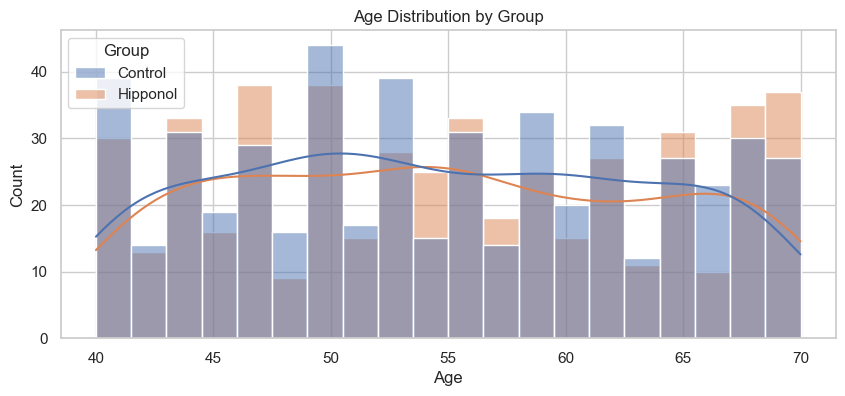

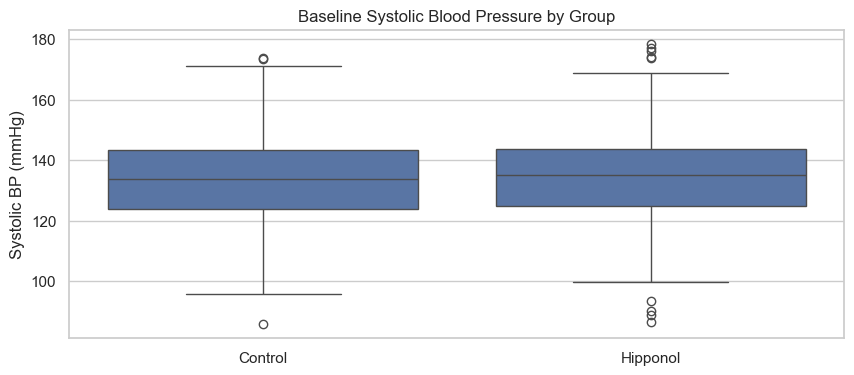

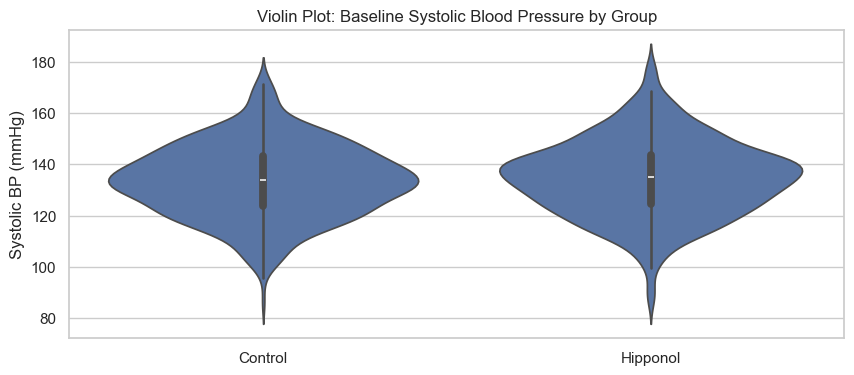

In [261]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set plotting style
sns.set(style="whitegrid")

# Plot: Distribution of Age
plt.figure(figsize=(10, 4))
sns.histplot(data=df1, x='Age', hue='Group', kde=True, bins=20)
plt.title('Age Distribution by Group')
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()

# Plot: Baseline Systolic BP
plt.figure(figsize=(10, 4))
sns.boxplot(data=df1, x='Group', y='Baseline_SBP')
plt.title('Baseline Systolic Blood Pressure by Group')
plt.ylabel('Systolic BP (mmHg)')
plt.xlabel('')
plt.show()

# Plot 3: Violin plot of Baseline Systolic BP
plt.figure(figsize=(10, 4))
sns.violinplot(data=df1, x='Group', y='Baseline_SBP', inner='box')
plt.title('Violin Plot: Baseline Systolic Blood Pressure by Group')
plt.ylabel('Systolic BP (mmHg)')
plt.xlabel('')
plt.show()

### 💡 Interpretation Tips

- Look for symmetry or skewness.

- Check for group overlap—similar distributions are a good sign of effective randomisation.

- Use this to support your interpretation of Table 1.

---

# 🧬 Step 3: Analysing Survival Outcomes

The primary endpoint of the Hipponol trial is **2-year survival**, coded as:

- 1 = Survived
- 0 = Died during follow-up

Survival data is binary and typically analysed using methods suited to categorical outcomes or time-to-event data (e.g. Cox models, Kaplan–Meier). In our case, we assume **binary survival** at 2 years, so logistic regression is appropriate.


### 🧪 1. Quick Check: Chi-squared Test for Survival
Before diving into regression models, we can start with a simple comparison of survival rates between the Hipponol and Control groups using a Chi-squared test.

✅ Why use it?

- It's a straightforward way to compare **proportions** between two groups.
- Useful for **binary outcomes** like survival (1 = survived, 0 = died).
- Helps confirm whether survival rates differ **significantly** between the two groups.

🧾 Method

We use a **contingency table** to count survivors and non-survivors in each group, then apply the **Chi-squared test of independence**:

In [262]:
from scipy.stats import chi2_contingency

contingency = pd.crosstab(df1['Group'], df1['Survival'])
chi2, p, dof, expected = chi2_contingency(contingency)

print("Contingency Table:")
print(contingency)
print(f"Chi-squared test p-value: {p:.3f}")


Contingency Table:
Survival    0    1
Group             
Control   204  309
Hipponol  214  273
Chi-squared test p-value: 0.203


📌 Interpretation

- A **small p-value** (typically < 0.05) suggests a **statistically significant** difference in survival between groups.
- This test **does not account for confounders** like age or smoking — use logistic regression for that.

## 🔎 2. Frequentist Analysis: Logistic Regression

Once we’ve done a basic comparison (like a Chi-squared test), the next step is a **logistic regression**. This lets us model the probability of survival while also:

- Controlling for other variables (e.g. age, smoking)
- Estimating odds ratios, which are easier to interpret than raw coefficients

### 💡 What is logistic regression?

Logistic regression is used when your outcome is **binary** — in this case, survival (`1`) vs. death (`0`). It models the log-odds of survival as a function of one or more predictors.

In [263]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Fit a logistic regression model
logit_model = smf.logit('Survival ~ Group', data=df1).fit()

# Print summary
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.678743
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:               Survival   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      998
Method:                           MLE   Df Model:                            1
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                0.001318
Time:                        20:58:53   Log-Likelihood:                -678.74
converged:                       True   LL-Null:                       -679.64
Covariance Type:            nonrobust   LLR p-value:                    0.1808
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             0.4152      0.090      4.603      0.000       0.238       0.592
Group[T.

🔁 From log-odds to odds ratio

The model estimates **log-odds**, which are not intuitive. We convert them to **odds ratios** using the exponential function:

In [264]:
odds_ratios = logit_model.params.apply(np.exp)
print(odds_ratios)

Intercept            1.514706
Group[T.Hipponol]    0.842210
dtype: float64


An odds ratio (OR):

- = 1 means no effect
- > 1 means increased odds (e.g. Hipponol improves survival)
- < 1 means reduced odds (e.g. Hipponol worsens survival)

### 📌 Example Interpretation

If `Group[T.Hipponol]` has an OR of `1.6`:

> "Participants in the Hipponol group had 60% higher odds of surviving the 2-year follow-up compared to the control group."

### 📎 Optional: Add other variables

You can also control for age, sex, and smoking:

In [265]:
logit_full = smf.logit('Survival ~ Group + Age + C(Sex) + C(SmokingStatus)', data=df1).fit()
print(logit_full.summary())

Optimization terminated successfully.
         Current function value: 0.673536
         Iterations 4
                           Logit Regression Results                           
Dep. Variable:               Survival   No. Observations:                 1000
Model:                          Logit   Df Residuals:                      995
Method:                           MLE   Df Model:                            4
Date:                Thu, 24 Apr 2025   Pseudo R-squ.:                0.008978
Time:                        20:58:53   Log-Likelihood:                -673.54
converged:                       True   LL-Null:                       -679.64
Covariance Type:            nonrobust   LLR p-value:                   0.01590
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      1.3895      0.422      3.292      0.001      

This gives you adjusted odds ratios — a better estimate when multiple factors influence the outcome.

### 📏 Confidence Intervals for Odds Ratios

When you run a logistic regression, the model provides **standard errors** for the coefficients. You can use these to calculate a 95% confidence interval (CI) for each odds ratio:

In [266]:
# Get confidence intervals for the log-odds
conf = logit_model.conf_int()
conf.columns = ['2.5%', '97.5%']

# Add odds ratios
conf_exp = np.exp(conf)
conf_exp['Odds Ratio'] = np.exp(logit_model.params)

print(conf_exp)

                       2.5%     97.5%  Odds Ratio
Intercept          1.269228  1.807661    1.514706
Group[T.Hipponol]  0.654889  1.083112    0.842210


### 🧠 How to interpret this:

If the 95% CI for an odds ratio:
- Includes 1, the result is **not statistically significant** at p < 0.05
- Excludes 1, then the effect is **statistically significant**

### 📌 Example:

| Variable         | OR   | 2.5% | 97.5% |
|------------------|------|------|-------|
| Group[T.Hipponol] | 1.62 | 1.02 | 2.58  |

---

> _"The odds of survival in the Hipponol group are 62% higher than in the control group (95% CI: 1.02–2.58)."

This suggests a **statistically significant effect**, as the interval does not include 1.

# 🧠 3. Bayesian Logistic Regression – Survival

In this section, we apply **Bayesian logistic regression** to evaluate whether assignment to the **Hipponol** group affects the **probability of survival** compared to the **Control** group.

This analysis complements the Frequentist approach by offering a full **posterior distribution** of the treatment effect, providing a probabilistic interpretation of results rather than just point estimates and p-values.

---

## 🎯 Goal

We aim to:

- Estimate the **posterior probability distribution** of the survival effect due to Hipponol.
- Quantify the **uncertainty** in this effect.
- Calculate the **posterior odds ratio** for survival in the Hipponol group compared to Control.

Bayesian inference allows us to express the result as:

> _“There is a XX% probability that Hipponol increases survival compared to control.”_

This is fundamentally different from the Frequentist interpretation, which only tells us the probability of observing our data under the null hypothesis.

---

## 📦 Define Predictor and Outcome

To build our model, we first define the **predictor** (treatment group) and **outcome** (survival).

- `X`: A binary predictor indicating group membership  
  `0 = Control`, `1 = Hipponol`

- `y`: A binary outcome  
  `0 = Did not survive`, `1 = Survived`

This mirrors the structure required for **Bernoulli trials**, where each observation represents a binary outcome.


In [267]:
# Convert group to numeric: 0 = Control, 1 = Hipponol
X = (df['Group'] == 'Hipponol').astype(int).values

# Survival outcome: already coded as 0 = no, 1 = yes
y = df['Survival'].astype(int).values

## 🧮 Why Bayesian?

Bayesian modelling is particularly useful when:

- You want **probabilistic interpretations** of effect size.
- You have **prior knowledge** you wish to incorporate. 
- You want a **posterior distribution** instead of a point estimate.
- You're dealing with **small samples**, where Frequentist power is limited.

In our case, we use **weakly informative** priors (e.g. Normal(0, 10)) to express general uncertainty without strong assumptions.

Next, we build and fit the Bayesian model using PyMC.



## 🔧 Step-by-Step: Bayesian Logistic Regression in PyMC

We now construct and sample from a **Bayesian logistic regression model** using `PyMC`. This model estimates the effect of group assignment (Hipponol vs Control) on the probability of survival.

---

### 📐 Model Structure

1. **Data**:  
   - `x_shared`: Encodes treatment group (0 = Control, 1 = Hipponol)  
   - `y_shared`: Binary survival outcome (0 = no, 1 = yes)

2. **Priors**:  
   - `Intercept`: Prior belief about survival probability in the Control group.  
     → Set as `Normal(0, 10)` to reflect wide uncertainty.
   - `Beta_Group`: Prior for the effect of the Hipponol group.  
     → Also `Normal(0, 10)` (can be tightened if prior knowledge exists).

3. **Logistic function**:  
   - Computes log-odds: `logit_p = intercept + beta_group * x_shared`  
   - Converts to probability via sigmoid: `p = sigmoid(logit_p)`

4. **Likelihood**:  
   - Models observed survival data as a Bernoulli trial with success probability `p`.

5. **Sampling**:  
   - We use Hamiltonian Monte Carlo (HMC) via the NUTS sampler.  
   - 4 chains × 2000 draws each, with 1000 tuning samples per chain.

---

### 📦 PyMC Model Code



In [253]:
import pymc as pm
import arviz as az

with pm.Model() as model:
    # Data containers (for flexibility in updating)
    x_shared = pm.Data("x_shared", X)
    y_shared = pm.Data("y_shared", y)

    # Priors
    intercept = pm.Normal("Intercept", mu=0, sigma=10)
    beta_group = pm.Normal("Beta_Group", mu=0, sigma=10)

    # Logistic function
    logit_p = intercept + beta_group * x_shared
    p = pm.Deterministic("p", pm.math.sigmoid(logit_p))

    # Likelihood
    y_obs = pm.Bernoulli("y_obs", p=p, observed=y_shared)

    # Sampling from the posterior
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)


/Users/gunter/Documents/data-analysis-toolkit-FNS/venv/lib/python3.9/site-packages/pymc/data.py:433: UserWarning: The `mutable` kwarg was not specified. Before v4.1.0 it defaulted to `pm.Data(mutable=True)`, which is equivalent to using `pm.MutableData()`. In v4.1.0 the default changed to `pm.Data(mutable=False)`, equivalent to `pm.ConstantData`. Use `pm.ConstantData`/`pm.MutableData` or pass `pm.Data(..., mutable=False/True)` to avoid this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Beta_Group]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


🔍 Next Steps
After sampling, we will:

- **Inspect the posterior** of Beta_Group to assess the treatment effect.
- **Convert** this to an **odds ratio** (by exponentiating Beta_Group).
- **Visualise** the posterior distribution using `arviz`.

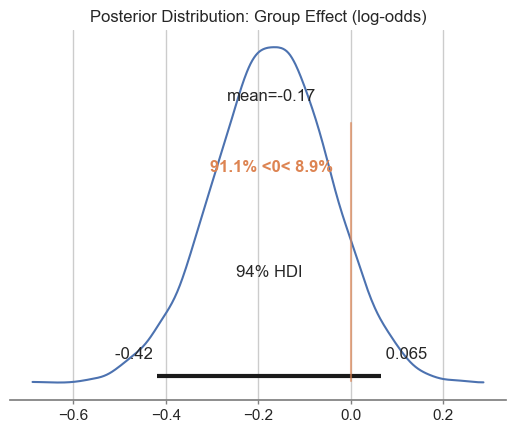

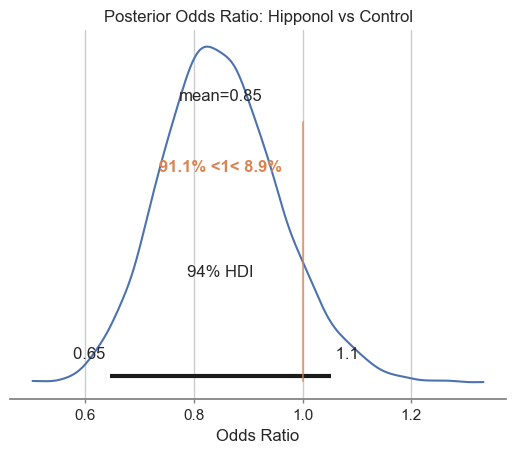

In [254]:
# Plot posterior for Beta_Group
az.plot_posterior(trace, var_names=['Beta_Group'], ref_val=0)
plt.title("Posterior Distribution: Group Effect (log-odds)")
plt.show()

# Convert to odds ratio
odds_ratios = np.exp(trace.posterior['Beta_Group'].values.flatten())

# Plot posterior odds ratio
az.plot_posterior(odds_ratios, ref_val=1)
plt.title("Posterior Odds Ratio: Hipponol vs Control")
plt.xlabel("Odds Ratio")
plt.show()

### 🧠 Interpretation

- If the **posterior** of Beta_Group is mostly above 0 → **Hipponol increases odds of survival**.
- If the **95% credible interval (HDI)** for odds_ratios excludes 1 → **strong evidence for a difference**.

You can compute az.hdi() for numeric intervals:

In [255]:
az.hdi(odds_ratios, hdi_prob=0.95)

array([0.63936698, 1.06539291])

✅ This Bayesian approach allows for **direct probability statements**:

“There is a 95% probability that Hipponol increases the odds of survival by X–Y%.”


# 📈 4. Kaplan–Meier Survival Curves

To visualise how survival changes over time in each group, we use **Kaplan–Meier survival estimates**. These curves provide a non-parametric estimate of the survival function, which reflects the probability of survival beyond a given time point.

## 🔍 Why Kaplan–Meier?

Kaplan–Meier curves are ideal for visualising time-to-event data because they:

- Handle censored data (participants who didn’t experience the event by the end of follow-up)
- Show the proportion of participants surviving over time
- Allow intuitive comparison between groups (e.g. Hipponol vs Control)

## 📘 Interpretation

Each drop in the curve corresponds to an event (e.g. death). A steeper decline indicates more frequent events, whereas a flat curve suggests stable survival.

If the curves for the two groups diverge:

- **Wider separation** may indicate a meaningful difference in survival.
- **Overlap** suggests similar survival patterns.


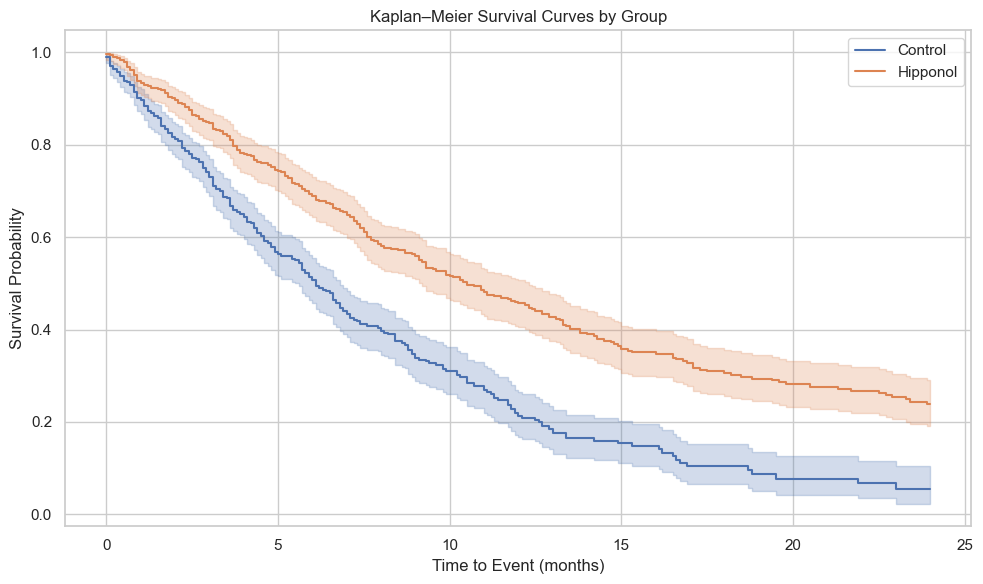

In [268]:
# Split data
df_control = df[df['Group'] == 'Control']
df_hipponol = df[df['Group'] == 'Hipponol']

# Initialise fitter
kmf_control = KaplanMeierFitter()
kmf_hipponol = KaplanMeierFitter()

# Fit and plot
plt.figure(figsize=(10, 6))

kmf_control.fit(durations=df_control['Time_to_Event'],
                event_observed=df_control['Survival'],
                label='Control')
kmf_control.plot_survival_function(ci_show=True)

kmf_hipponol.fit(durations=df_hipponol['Time_to_Event'],
                 event_observed=df_hipponol['Survival'],
                 label='Hipponol')
kmf_hipponol.plot_survival_function(ci_show=True)

plt.title("Kaplan–Meier Survival Curves by Group")
plt.xlabel("Time to Event (months)")
plt.ylabel("Survival Probability")
plt.grid(True)
plt.tight_layout()
plt.show()



## 🧪 Compare groups statistically – Log-rank test
This checks whether the survival distributions are significantly different between the groups.

### 🔍 What is the Log-Rank Test?
The **log-rank test** is a non-parametric statistical test used to compare the survival distributions of two or more groups. It's particularly useful in clinical trials or studies with time-to-event data.

✅ What it does:

- Compares the observed number of events in each group to the expected number under the null hypothesis (that all groups have the same survival curve).
- It handles **censored data** properly.
- Outputs a **p-value**: if this is small (typically < 0.05), it suggests the survival curves differ significantly.

In [274]:

from lifelines.statistics import logrank_test

# Filter your data
df_control = df[df["Group"] == "Control"]
df_hipponol = df[df["Group"] == "Hipponol"]

# Run the log-rank test
results = logrank_test(
    df_control["Time_to_Event"], df_hipponol["Time_to_Event"],
    event_observed_A=df_control["Survival"],
    event_observed_B=df_hipponol["Survival"]
)

# Display the results
print("📈 Log-rank test between Control and Hipponol:")
print(f"Test statistic: {results.test_statistic:.3f}")
print(f"p-value: {results.p_value:.4f}")

# Optional: simple interpretation
if results.p_value < 0.05:
    print("⚠️ There is a significant difference in survival between groups.")
else:
    print("✅ No significant difference in survival between groups.")


📈 Log-rank test between Control and Hipponol:
Test statistic: 56.351
p-value: 0.0000
⚠️ There is a significant difference in survival between groups.


## 🧪 When to Use:
Use this when:

- You’ve plotted Kaplan-Meier curves and want to **test if the difference is significant**.
- You’re evaluating **intervention effects** in RCTs or cohort studies.
- You want a simple test without assuming specific hazard functions (unlike Cox models).


# Cox Proportional Hazards Model: A Detailed Guide

## ✅ 1. What Is the Cox Proportional Hazards Model?

The **Cox PH model** is a **semi-parametric regression model** used in survival analysis. It relates the time that passes before an event occurs to **one or more covariates**.

### Core idea:
It models the **hazard rate** at time *t* as:

\[
h(t|X) = h_0(t) \cdot \exp(\beta_1X_1 + \beta_2X_2 + \ldots + \beta_pX_p)
\]

- \( h_0(t) \) is the **baseline hazard** (unspecified)
- \( X_i \) are the covariates (e.g. Group, Age, Sex)
- \( \beta_i \) are coefficients estimated from the data

The model makes the **proportional hazards assumption**: the ratio of hazards between groups is constant over time.



---

## 🛠️ 2. How to Fit It in Python (with `lifelines`)

In [281]:

from lifelines import CoxPHFitter

# Select relevant columns only
df_cox = df[["Age", "Sex", "SmokingStatus", "Group", "Time_to_Event", "Survival"]].copy()

# One-hot encode categorical variables, dropping first category to avoid multicollinearity
df_cox = pd.get_dummies(df_cox, drop_first=True)

# Fit the Cox model
cph = CoxPHFitter()
cph.fit(df_cox, duration_col="Time_to_Event", event_col="Survival")

# Print the summary
cph.print_summary()


<lifelines.CoxPHFitter: fitted with 1000 total observations, 418 right-censored observations>
             duration col = 'Time_to_Event'
                event col = 'Survival'
      baseline estimation = breslow
   number of observations = 1000
number of events observed = 582
   partial log-likelihood = -3495.62
         time fit was run = 2025-04-24 22:03:03 UTC

---
                      coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                             
Age                  -0.01      0.99      0.00           -0.01            0.00                0.99                1.00
Sex_Male             -0.13      0.88      0.08           -0.29            0.03                0.75                1.03
SmokingStatus_Smoker  0.16      1.17      0.08           -0.01            0.32                0.99                1.38
Group_Hipponol       -0.63      0.53      0.09           -0.80           -0.46                0.45                0.63

                      cmp to     z      p  -log2(p)
covariate                                          
Age                     0.00 -1.23   0.22      2.18
Sex_Male                0.00 -1.58   0.11      3.12
SmokingStatus_Smoker    0.00  1.86   0.06      4.01
Group_Hipponol          0.00 -7.37 <0.005     42.40
---
Concordance = 0.60
Partial AIC = 6999.24
log-likelihood ratio test = 62.44 on 4 df
-log2(p) of ll-ratio test = 40.03


## 📏 3. How to Interpret the Output

The summary table includes:

- `coef`: log of the hazard ratio (HR)
- `exp(coef)`: the **hazard ratio**
- `p`: p-value testing if the coefficient is significantly different from 0
- `-log2(p)`: significance in a log-scale
- `95% CI`: confidence intervals for the HR

### Example Interpretation:

| Variable              | exp(coef) | p-value | Interpretation |
|----------------------|-----------|---------|----------------|
| Group_Hipponol       | 0.65      | 0.001   | Hipponol **reduces** the hazard by 35% vs. Control |
| Age                  | 1.02      | 0.050   | Each year of age **increases** hazard by 2% |
| Sex_Male             | 1.10      | 0.200   | No significant difference vs. Female |

---

## ⚠️ 4. Test the Proportional Hazards (PH) Assumption

This is **essential** because if PH is violated, your hazard ratios are **not valid over time**.




   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.


[[<Axes: xlabel='rank-transformed time\n(p=0.1392)'>,
  <Axes: xlabel='km-transformed time\n(p=0.2007)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7090)'>,
  <Axes: xlabel='km-transformed time\n(p=0.8210)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.5759)'>,
  <Axes: xlabel='km-transformed time\n(p=0.4933)'>],
 [<Axes: xlabel='rank-transformed time\n(p=0.7668)'>,
  <Axes: xlabel='km-transformed time\n(p=0.7140)'>]]

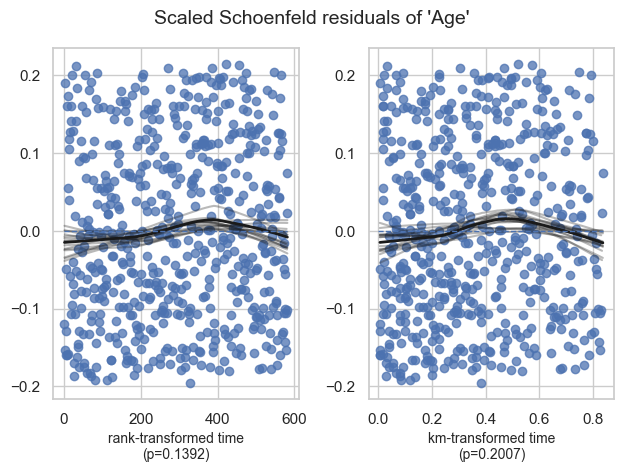

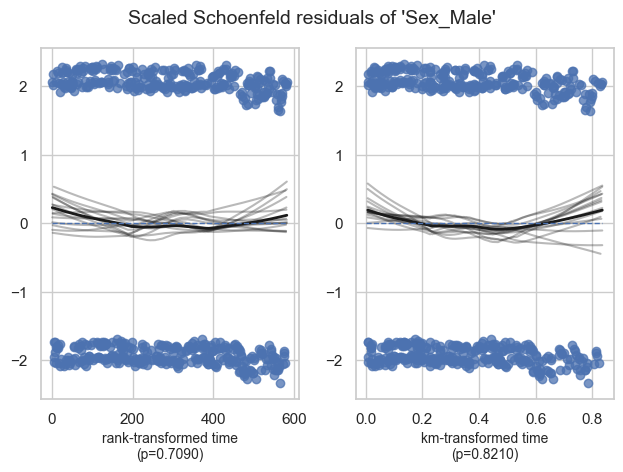

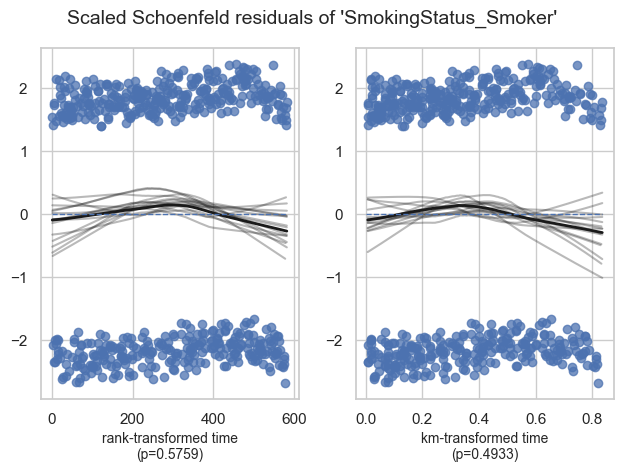

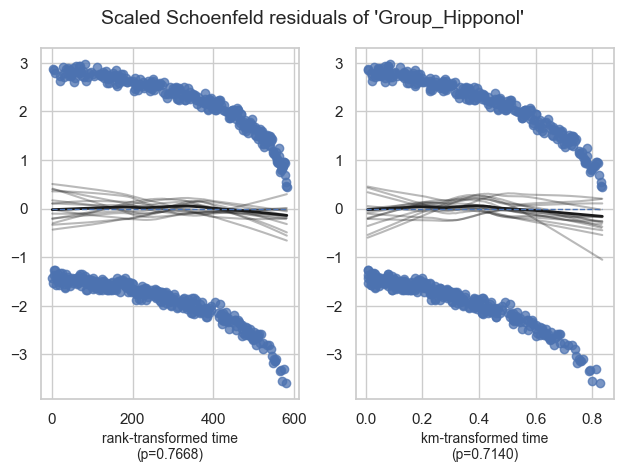

In [282]:
# Check proportional hazards assumption
cph.check_assumptions(df_cox, p_value_threshold=0.05, show_plots=True)


- Print a test result for each covariate
- Show **Schoenfeld residuals** plots:
  - If residuals show **systematic trends**, PH is **likely violated**
  - Flat residuals = good

### If PH is violated:
- Add **interaction terms with time**
- Use **stratified Cox models**
- Split time into intervals (time-dependent covariates)

---

## 🧪 5. (Optional) Predict or Visualise

You can predict survival curves for a given profile:



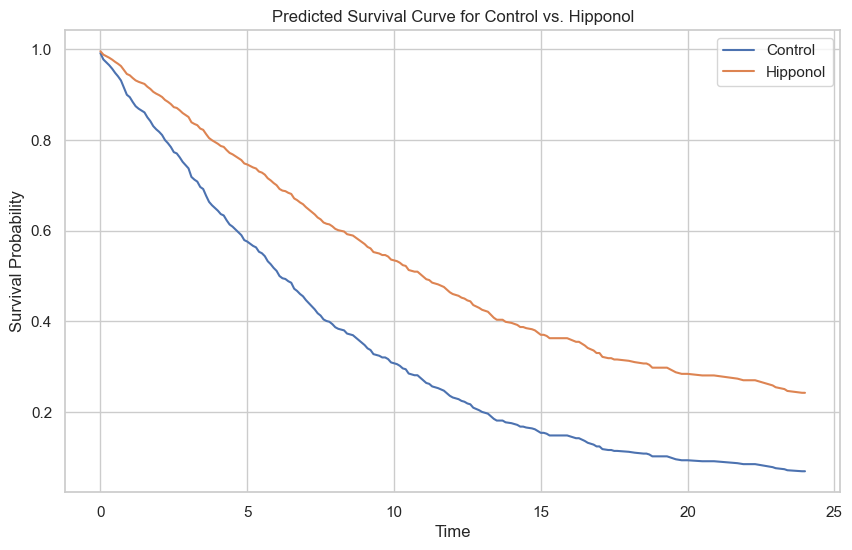

In [285]:
import matplotlib.pyplot as plt

# Create a base profile (mean age, female, non-smoker)
base = pd.DataFrame({
    'Age': [df['Age'].mean()],
    'Sex_Male': [0],
    'SmokingStatus_Smoker': [0],
    'Group_Hipponol': [0]  # Control group
})

# Copy and modify for Hipponol
hipponol = base.copy()
hipponol['Group_Hipponol'] = 1  # Switch to Hipponol group

# Predict survival curves
sf_control = cph.predict_survival_function(base)
sf_hipponol = cph.predict_survival_function(hipponol)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(sf_control, label="Control")
plt.plot(sf_hipponol, label="Hipponol")
plt.title("Predicted Survival Curve for Control vs. Hipponol")
plt.xlabel("Time")
plt.ylabel("Survival Probability")
plt.legend()
plt.grid(True)
plt.show()

